### Imports

In [55]:
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from time import process_time as clock
from time import sleep
from astropy.io import fits
import urllib.request
import os.path
from ppxf_wrap import ppxf_wrap
import scipy.stats as stats

In [ ]:
%matplotlib inline

# MaNGA Rotation Curve Exercise

**Heavily** adapted from Haeun Cheung's MaNGA rotation curve tutorial @ https://github.com/astrohchung/manga_rc_tuto. Please support the original author of this exercise!

Step 1. Download MaNGA data and catalog

Start downloading manga-8329-6103-LOGCUBE.fits.gz from SDSS server. This may take several minutes.
Download complete
Start downloading drpall-v2_1_2.fits from SDSS server. This may take several seconds.
Download complete
Start downloading 8329-6103.png from SDSS server. This may take several seconds.
Download complete


(np.float64(-0.5), np.float64(561.5), np.float64(561.5), np.float64(-0.5))

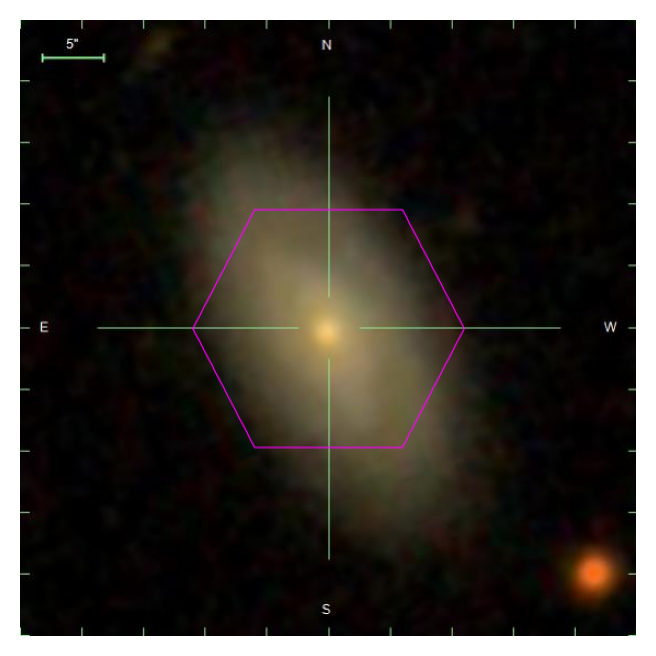

In [5]:
#if certificate error occurs, repeat this cell after several seconds of break

# plateifu of galaxy to download data
plateifu='8329-6103' # Spiral Galaxy
# plateifu='8137-6103' # Elliptical Galaxy


plate, ifuname=plateifu.split('-')
cdir='./'  #current directory

# MaNGA cube file
cube_file='manga-'+plateifu+'-LOGCUBE.fits.gz'   # file to de downloaded
sleeptime=4 #intentional gap between downloads

# download MaNGA cube file if not exist.
if not os.path.isfile(cdir+cube_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Started downloading "+cube_file+" from SDSS server. This may take several minutes.")
    down_url=sas_url+plate+'/stack/'+cube_file
    urllib.request.urlretrieve(down_url, cdir+cube_file)
    print('Download complete')
    sleep(sleeptime)


# MaNGA Catalog file (DR14)
drpall_file="drpall-v2_1_2.fits"

# download drpall file if not exist.
if not os.path.isfile(cdir+drpall_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Started downloading "+drpall_file+" from SDSS server. This may take several seconds.")
    down_url=sas_url+"drpall-v2_1_2.fits"
    urllib.request.urlretrieve(down_url, cdir+drpall_file)    
    print('Download complete')
    sleep(sleeptime)
    
image_file=plateifu+'.png'
if not os.path.isfile(cdir+image_file):
    sas_url="https://data.sdss.org/sas/dr14/manga/spectro/redux/v2_1_2/"
    print("Started downloading "+image_file+" from SDSS server. This may take several seconds.")
    down_url=sas_url+plate+'/stack/images/'+ifuname+'.png'
    urllib.request.urlretrieve(sas_url+plate+'/stack/images/'+ifuname+'.png', cdir+image_file)
    print('Download complete')
    
# Show MaNGA galaxy image
fig=plt.figure(figsize=(4,4), dpi=200)
plt.imshow(mpimg.imread(cdir+image_file),aspect='equal')
plt.axis('off')

2. Read galaxy information from the downloaded catalog

In [7]:
drpall=fits.open(cdir+drpall_file)
tbdata=drpall[1].data
idx=np.where(tbdata['plateifu'] == plateifu)
objra=tbdata['objra'][idx][0]
objdec=tbdata['objdec'][idx][0]
nsa_z=tbdata['nsa_z'][idx][0]
nsa_elpetro_phi=tbdata['nsa_elpetro_phi'][idx][0]
nsa_elpetro_ba=tbdata['nsa_elpetro_ba'][idx][0]

print("Galaxy: ",plateifu)
print("RA, DEC:", objra, ',',objdec)
print("Redshift: ",nsa_z)
print("Position angle (degree): ", nsa_elpetro_phi)
print("b/a ratio: ", nsa_elpetro_ba)
print('More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=%0.6f&dec=%0.6f&scale=0.2' % (objra, objdec))

# print(tbdata.columns.names)

Galaxy:  8329-6103
RA, DEC: 213.103435454 , 44.4608684501
Redshift:  0.0312672
Position angle (degree):  28.8381
b/a ratio:  0.641807
More info: http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=213.103435&dec=44.460868&scale=0.2


3. Load in flux, variance, and masking data

In [9]:
# Open and read flux, inverse variance, and mask cube.
cube = fits.open(cdir+cube_file)
flux=np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar=np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))
wave = cube['WAVE'].data
specres = cube['SPECRES'].data

flux_header = cube['FLUX'].header

4. Plot a spectrum for the center of the galaxy

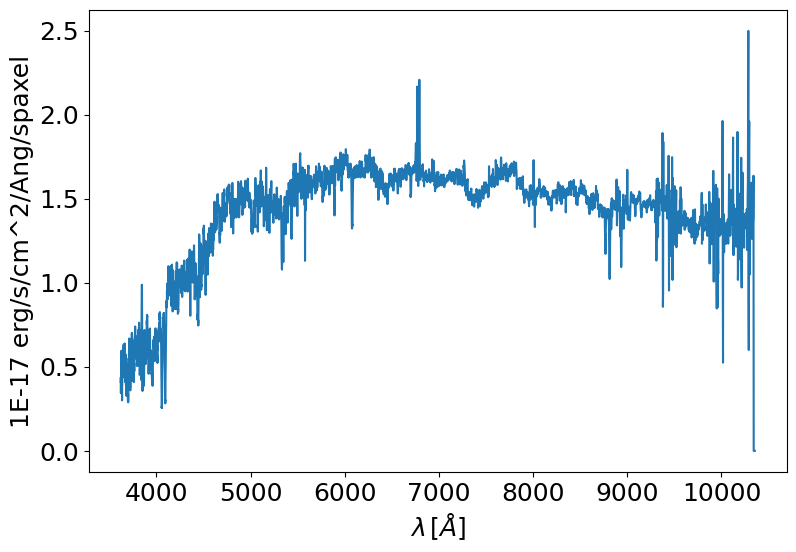

Cube 2D size:  54 by 54


In [16]:
#plot manga spectrum at the center
x_center = int(flux_header['CRPIX1']) - 1
y_center = int(flux_header['CRPIX2']) - 1

x_plot=x_center
y_plot=y_center

# User can plot other part of the galaxy
#x_plot=28
#y_plot=35

# fig=plt.figure(figsize=(9, 6))
matplotlib.rcParams['figure.figsize'] = [9, 6]
matplotlib.rc('font', family='sans-serif', size=18)
plt.plot(wave, flux[x_plot, y_plot])
plt.xlabel(r'$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])
plt.show()
# plt.rcParams['figure.figsize'] = [9, 6]

print('Cube 2D size: ', flux.shape[0], 'by', flux.shape[1])

5. H$\alpha$ intensity map -- this is what we make the rotation curve from!

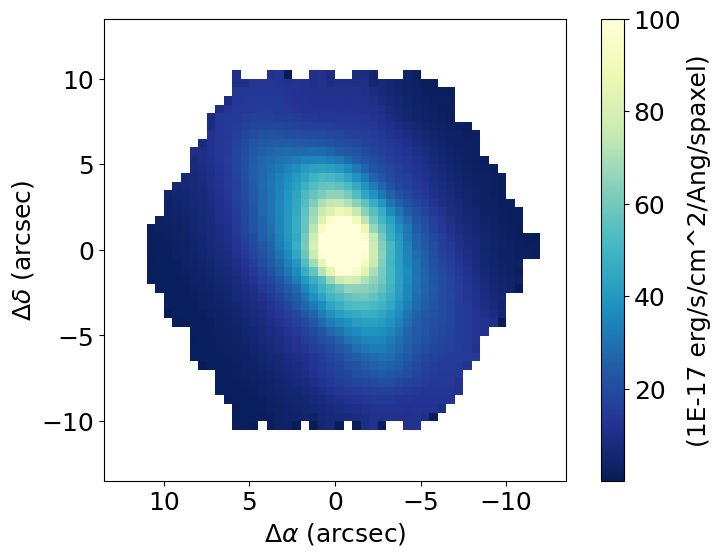

In [266]:
# process flux data 
do_not_use = (mask & 2**10) > 0
flux_m = np.ma.array(flux, mask=do_not_use)
ivar_m = np.ma.array(ivar, mask=do_not_use)

min_wave=6550
max_wave=6680
redshift = nsa_z
ind_wave = np.where((wave / (1 + redshift) > min_wave) & (wave / (1 + redshift) < max_wave))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2) # integrate flux along wavelength vector
im = halpha.T #Transpose numpy array

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label='('+flux_header['BUNIT']+')')
plt.xlabel(r'$\Delta \alpha $ (arcsec)')
plt.ylabel(r'$\Delta \delta $ (arcsec)')
plt.show()

6. Extract galaxy kinematics with pPXF

<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
/var/folders/_l/lctpkf853fgf3f5_984ttyt00000gn/T/ipykernel_22662/4239092347.py:41: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda \, [\AA]$')
/opt/anaconda3/envs/stenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/theodorepena/Downloads/Work/GitHub/manga-rotation-curve/ppxf_wrap.py:104: RuntimeWarning: divide by zero encountered in power
  noise=((self.ivar**(-0.5))[wave_mask])


List of galaxy template files:  ['./Mun1.30Zp0.00T01.9953_iPp0.00_baseFe_linear_FWHM_2.51.fits', './Mun1.30Zp0.00T07.9433_iPp0.00_baseFe_linear_FWHM_2.51.fits', './Mun1.30Zp0.00T10.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits', './Mun1.30Zp0.00T01.0000_iPp0.00_baseFe_linear_FWHM_2.51.fits']
 i  j   Velocity Dispersion  Chi2    t
22 06     39.699    118.591  0.90  0.0
25 06     94.290     58.521  1.00  0.0
26 06    129.291     72.732  1.00  0.0
30 06    150.629     49.253  0.98  0.0
19 07   1282.964    195.870  1.01  0.0
20 07     51.645      0.690  0.99  0.0
21 07     64.277      0.690  0.98  0.0
22 07     69.766     31.897  0.97  0.0
23 07     78.950     54.067  0.95  0.0
24 07     86.569     61.888  0.96  0.0
25 07    102.682     71.990  0.99  0.0
26 07    122.941     60.333  1.01  0.0
27 07    137.844     54.300  1.00  0.0
28 07    148.749     52.433  0.99  0.0
29 07    148.938     51.628  0.98  0.0
30 07    145.424     48.991  0.96  0.0
31 07    146.017     32.597  0.96  0.0
32 07    

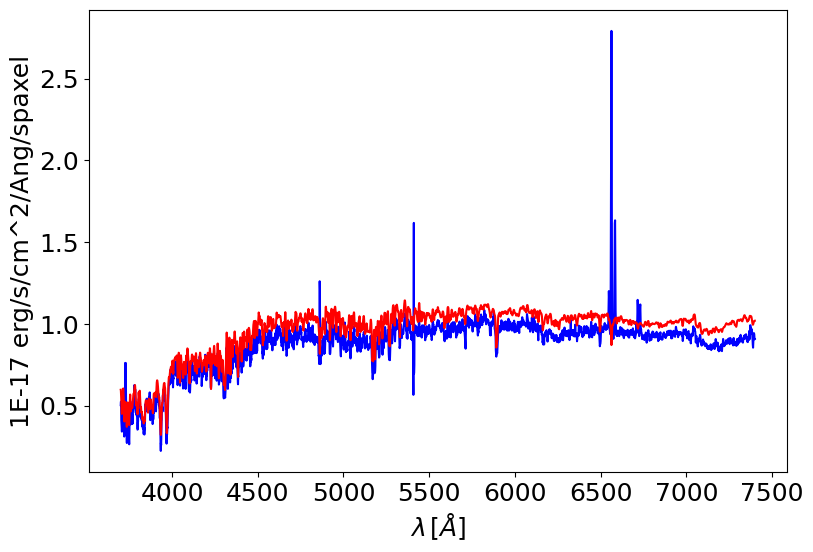

In [18]:
run_vel_measure=True

oname=cdir+'manga-'+plateifu+'-LOGCUBE_MAPS.fits'

# i, j index of spaxel to show comaparison result
check_i=27
check_j=27
if run_vel_measure:
    redshift=nsa_z
    ppxf_obj=ppxf_wrap(redshift, wave, specres)
    nx, ny, _ = flux.shape
    resarr=np.zeros((nx,ny))
    flagarr=np.zeros((nx,ny),dtype=np.int16) #define flag array
    t = clock()
    check_flag=False
    wave_mask = (wave > 3700) & (wave < 7400)
    print("%2s %2s %10s %10s %5s %4s" % ('i', 'j', 'Velocity', 'Dispersion', 'Chi2', 't'))
    for j in rangenx):
        for i in range(ny):
            t = clock()
            mm_mask=((mask[j,i] & 2**10) == 0)
            if ((np.median(flux_m[i,j]) > 0) and (np.sum(mm_mask[wave_mask])>10)):
                ppxf_obj.flux=flux[i,j]
                ppxf_obj.ivar=ivar[i,j]
                ppxf_obj.mask=mm_mask
                
                res=ppxf_obj.run()
                if not res:
                    continue
                resarr[i,j]=res.sol[0]
                flagarr[i,j]=1
                if i == check_i & j == check_j:
                    check_flag=True
                    sflux=ppxf_obj.flux
                    sbestfit=res.bestfit
                print("%02d %02d %10.3f %10.3f %5.2f %4.1f" % (i, j, res.sol[0], res.sol[1], res.chi2, clock()-t))

    if check_flag:
        plt.plot(ppxf_obj.lam_gal, sflux[ppxf_obj.wave_mask], 'b-')
        plt.plot(ppxf_obj.lam_gal, sbestfit, 'r-')
        plt.xlabel('$\lambda \, [\AA]$')
        plt.ylabel(flux_header['BUNIT'])

    print('Save velocity measurement data in to FITS file: ', oname)
    hdu = fits.PrimaryHDU()
    hdu.writeto(oname, overwrite=True)

    fits.append(oname, resarr)
    fits.append(oname, flagarr.astype(np.int16))

    append_file=fits.open(oname, mode='update')

    hdr=append_file[1].header
    hdr.set('EXTNAME','STELLAR_VEL')
    hdr=append_file[2].header
    hdr['EXTNAME']='FLAG'

    append_file.close()

7. Create the velocity map plot

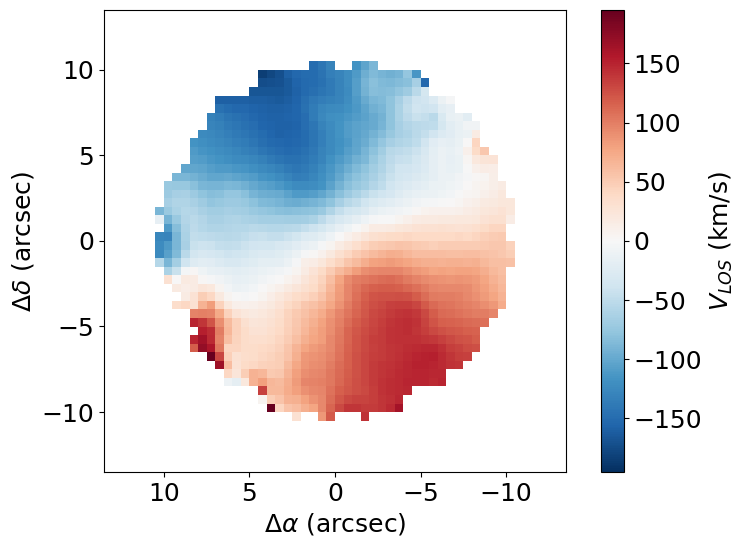

In [145]:
# read velocity map file
rfile='manga-'+plateifu+'-LOGCUBE_MAPS.fits'
if not os.path.isfile(cdir+rfile): # use pre-saved file if above one not exist.
    rfile='manga-'+plateifu+'-LOGCUBE_MAPS_SAVED.fits'
    
cube = fits.open(cdir+rfile)
velmap=cube['STELLAR_VEL'].data
nx, ny=velmap.shape

# Plot 2D map
# Calculate velocity statistics (median and standard deviation) to re-scale map values for plot)
pvelmap=velmap.T
zero_idx=(pvelmap == 0)
pvelmap[zero_idx]=np.nan
finite_idx=np.isfinite(pvelmap)
medv, stdv, sigv=(np.median(pvelmap[finite_idx]), np.std(pvelmap[finite_idx]), 2)
pvelmap=pvelmap-medv

cmap= matplotlib.cm.RdBu_r.copy()
cmap.set_bad(color='white')
plt.imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
plt.colorbar(label='$V_{LOS}$ (km/s)')
plt.xlabel(r'$\Delta \alpha $ (arcsec)')
plt.ylabel(r'$\Delta \delta $ (arcsec)')
plt.show()

8. Make the double-peaked LoS velocity curve

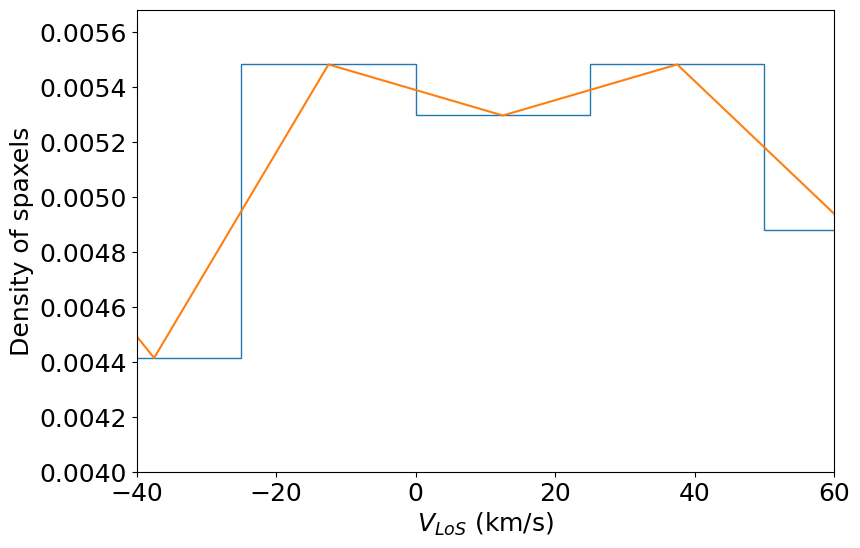

In [123]:
unpacked_vels = []
for i in range(pvelmap.shape[0]):
    for j in range(pvelmap.shape[1]):
        if not np.isnan(pvelmap[i][j]):
            unpacked_vels.append(pvelmap[i][j])

n, x, _ = plt.hist(unpacked_vels,bins=np.linspace(-100,100,9), density=True, histtype='step')
bin_centers = 0.5*(x[1:]+x[:-1])
bin_centers = [-100] + list(bin_centers) + [100]
plt.plot(bin_centers, [0]+list(n)+[0])
plt.ylim(0.004, np.max(n)+0.0002)
plt.xlim(-40, 60)
plt.xlabel(r'$V_{LoS}$ (km/s)', loc='center')
plt.ylabel(r'Density of spaxels')

plt.show()

## Combine everything for a full plot

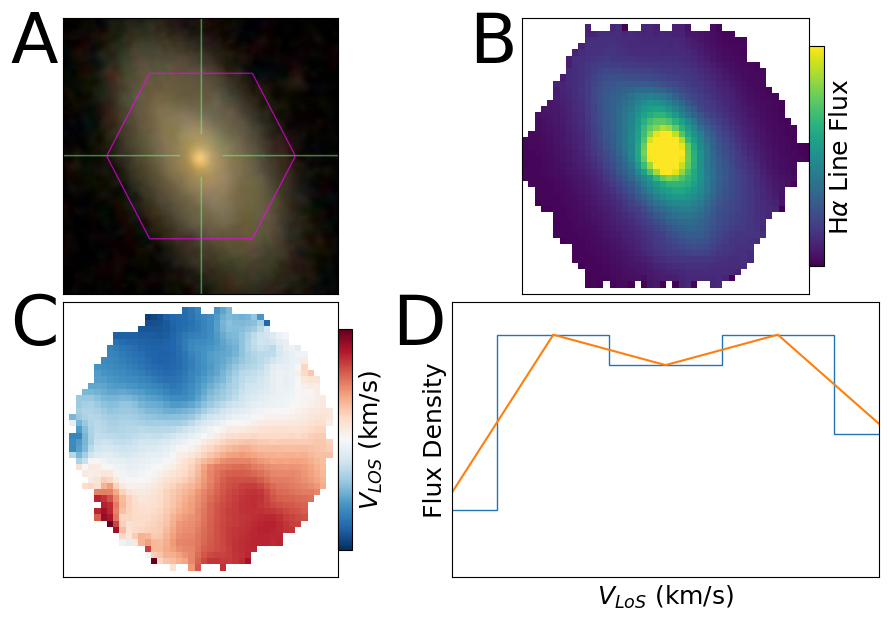

In [325]:
# Vertical spacing for row two, plots C and D. Counts up from the bottom of the figure
row_two_spacing = 0.45

### Figure managment
fig, ax = plt.subplots(2, 2, layout='constrained')
## Label for image A
fig.text(0.03,0.92, "A", fontsize=50, fontfamily='sans-serif')

# Load in .png of galaxy and crop to fill the figure
ax[0,0].imshow(mpimg.imread(cdir+image_file),aspect='equal')
ax[0,0].set_xlim(100,462)
ax[0,0].set_ylim(462,100)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

## Label for image B
fig.text(0.54,0.92, "B", fontsize=50, fontfamily='sans-serif')
# Load in halpha line flux plot
halpha = ax[0,1].imshow(im, extent=extent, cmap='viridis', vmin=0.1, vmax=100, origin='lower', interpolation='none')
cax = ax[0,1].inset_axes([1.0, 0.1, 0.05, 0.8])
fig.colorbar(halpha, cax=cax, ticks=[], label=r'H$\alpha$ Line Flux')

# Crop to the content
ax[0,1].set_xlim(11,-12)
ax[0,1].set_ylim(-11,11)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

## Label for image C
fig.text(0.03, row_two_spacing, "C", fontsize=50, fontfamily='sans-serif')
# Load in line-of-sight velocity map
vmap = ax[1,0].imshow(pvelmap, extent=extent, cmap=cmap, vmin=(-stdv*sigv), vmax=stdv*sigv, origin='lower', interpolation='none')
cax = ax[1,0].inset_axes([1.0, 0.1, 0.05, 0.8])
fig.colorbar(vmap, cax=cax, ticks=[], label='$V_{LOS}$ (km/s)')

# Crop to content
ax[1,0].set_xlim(11,-11)
ax[1,0].set_ylim(-11,11)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

## Label D
fig.text(0.455,row_two_spacing, "D", fontsize=50, fontfamily='sans-serif')
# Load in line global line profile
ax[1,1].hist(unpacked_vels,bins=np.linspace(-100,100,9), density=True, histtype='step')
# Overplot to highlight double-peaked structure
ax[1,1].plot(bin_centers, [0]+list(n)+[0])

# Crop to content
ax[1,1].set_ylim(0.004, np.max(n)+0.0002)
ax[1,1].set_xlim(-35, 60)
# Remove ticks for clarity? It's possible some readers might find the fact that this galaxy
# has a net peculiar velocity confusing.
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
# attach labels to the axes
ax[1,1].set_xlabel(r'$V_{LoS}$ (km/s)', loc='center')
ax[1,1].set_ylabel(r'Flux Density')


### Save .svg
plt.savefig('DoublePeakedRotationCurve.svg', format='svg')
plt.show()